# Load Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

# Load Files

In [2]:
users = pd.read_csv("/Users/Raymnd Diaz/GitHub/SpringboardWork/Relax/takehome_users.csv",encoding="ISO-8859-1")
engagement = pd.read_csv("/Users/Raymnd Diaz/GitHub/SpringboardWork/Relax/takehome_user_engagement.csv",encoding="ISO-8859-1")

In [3]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [4]:
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [5]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [6]:
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


# Create Adopted User Flag

In [7]:
engagement['time_stamp'] = pd.to_datetime(engagement['time_stamp'])
engagement['day'] = engagement['time_stamp'].dt.day

In [8]:
# Get a rolling count of logins
def get_rolling(df, freq):
    return df.rolling(freq, on='time_stamp')['visited'].count()

engagement['7days'] = engagement.groupby('user_id', as_index=False, group_keys=False).apply(get_rolling, freq='7D')

In [9]:
engagement.head(100)

,time_stamp,user_id,visited,day,7days
0,2014-04-22 03:53:30,1,1,22,1.0
1,2013-11-15 03:45:04,2,1,15,1.0
2,2013-11-29 03:45:04,2,1,29,1.0
3,2013-12-09 03:45:04,2,1,9,1.0
4,2013-12-25 03:45:04,2,1,25,1.0
...,...,...,...,...,...
95,2013-07-30 22:08:03,10,1,30,5.0
96,2013-08-02 22:08:03,10,1,2,4.0
97,2013-08-03 22:08:03,10,1,3,5.0
98,2013-08-04 22:08:03,10,1,4,5.0


In [10]:
adopted = engagement[engagement['7days'] >= 3].drop_duplicates('user_id',keep='first')

In [11]:
adopted.head()

,time_stamp,user_id,visited,day,7days
9,2014-02-09 03:45:04,2,1,9,3.0
27,2013-02-19 22:08:03,10,1,19,3.0
312,2014-03-13 11:46:38,20,1,13,3.0
331,2014-03-23 06:29:09,33,1,23,3.0
354,2012-12-26 19:05:07,42,1,26,3.0


In [12]:
adopted['adopted'] = True
adopted = adopted[['user_id','adopted']]
adopted.head()

,user_id,adopted
9,2,True
27,10,True
312,20,True
331,33,True
354,42,True


In [13]:
adopted_users = adopted.user_id.tolist()

In [14]:
len(adopted_users)

1602

# Merge Adopted to User File and Clean User File

In [15]:
users = users.rename(columns={'object_id': 'user_id'})

In [16]:
users['adopted'] = users['user_id'].isin(adopted_users)
users.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,False
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,True
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,False
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,False
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,False


In [17]:
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'],unit='s')
users.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,False
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,True
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,False
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,False
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,False


In [18]:
users['invited_by_user_id'] = users['invited_by_user_id'].fillna(0)
users['last_session_creation_time'] = users['last_session_creation_time'].fillna(users['creation_time'])

In [19]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   user_id                     12000 non-null  int64         
 1   creation_time               12000 non-null  object        
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  12000 non-null  datetime64[ns]
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          12000 non-null  float64       
 10  adopted                     12000 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(1), int64(4), o

In [20]:
# Create an email provider coluimn
users['emailProvider'] = [x.split('@')[1] for x in users.email]
topEmails = users.emailProvider.value_counts().index[:6]
users['emailProvider'] = [x if x in topEmails else 'Other' for x in users.emailProvider]

In [21]:
users.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,emailProvider
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,False,yahoo.com
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,True,gustr.com
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,False,gustr.com
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,False,yahoo.com
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,False,yahoo.com


# Do Some EDA on File

In [22]:
numerical = ['opted_in_to_mailing_list','enabled_for_marketing_drip','org_id','invited_by_user_id']

C:\Users\Raymnd Diaz\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


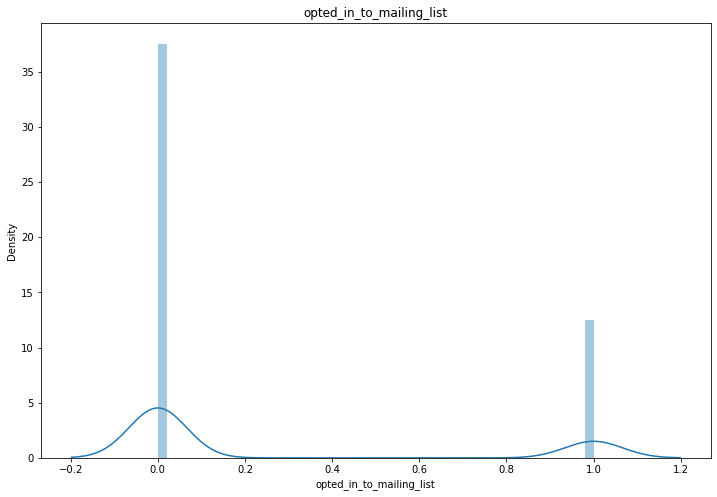

C:\Users\Raymnd Diaz\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


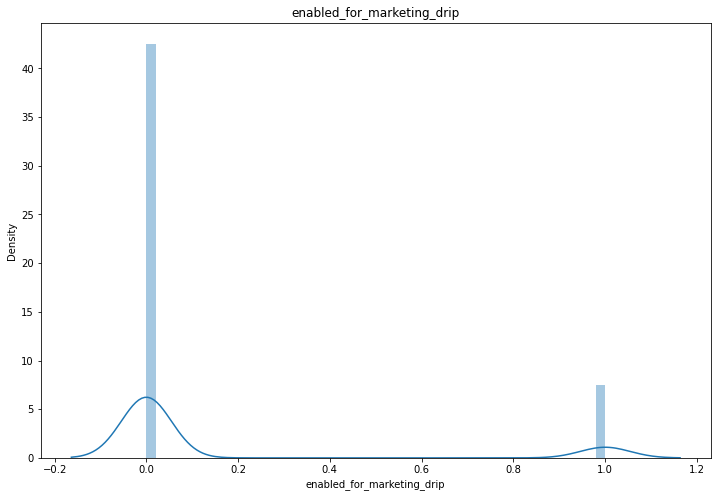

C:\Users\Raymnd Diaz\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


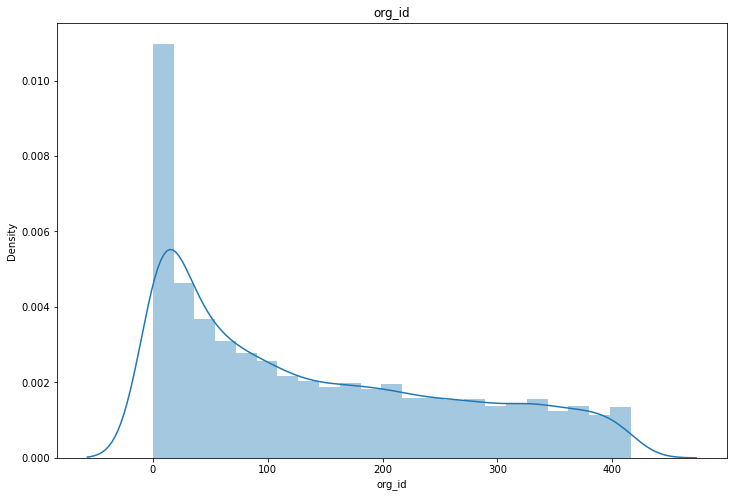

C:\Users\Raymnd Diaz\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


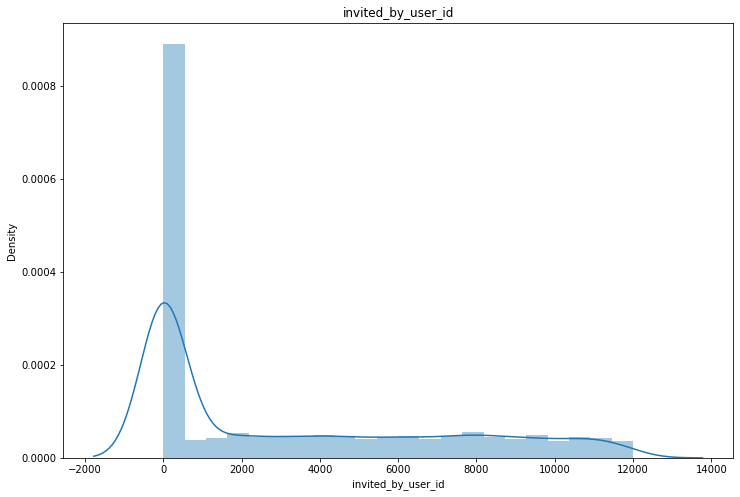

In [23]:
for num in numerical:
    plt.figure(figsize=(12,8))
    sns.distplot(users[num])
    plt.title(num)
    plt.show()

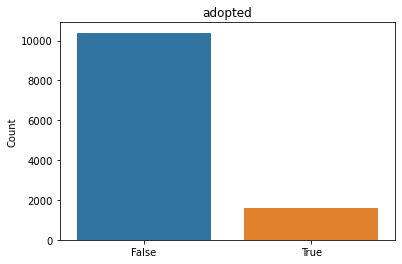

In [24]:
sns.barplot(data=users, x=users['adopted'].value_counts().index, y=users['adopted'].value_counts())
plt.title('adopted')
plt.ylabel('Count')
plt.show()

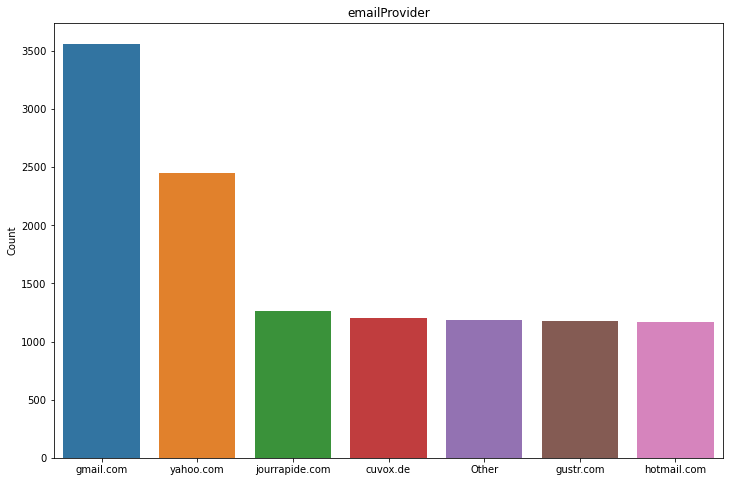

In [25]:
plt.figure(figsize=(12,8))
sns.barplot(data=users, x=users['emailProvider'].value_counts().index, y=users['emailProvider'].value_counts())
plt.title('emailProvider')
plt.ylabel('Count')
plt.show()

# Create Features, Run Random Forest Model and get Feature Importance

In [26]:
# Drop unnecessary fields and create features based off of EDA we see
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

df_model = users.drop(['email','name','creation_time','email','last_session_creation_time','user_id'],axis=1)
df_model = pd.get_dummies(df_model, columns=['creation_source'])
df_model['adopted'] = df_model['adopted'].astype(int)
df_model.emailProvider = le.fit_transform(df_model['emailProvider'])

df_model.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,emailProvider,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,1,0,11,10803.0,0,6,1,0,0,0,0
1,0,0,1,316.0,1,3,0,1,0,0,0
2,0,0,94,1525.0,0,3,0,1,0,0,0
3,0,0,1,5151.0,0,6,1,0,0,0,0
4,0,0,193,5240.0,0,6,1,0,0,0,0


In [27]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   opted_in_to_mailing_list            12000 non-null  int64  
 1   enabled_for_marketing_drip          12000 non-null  int64  
 2   org_id                              12000 non-null  int64  
 3   invited_by_user_id                  12000 non-null  float64
 4   adopted                             12000 non-null  int32  
 5   emailProvider                       12000 non-null  int32  
 6   creation_source_GUEST_INVITE        12000 non-null  uint8  
 7   creation_source_ORG_INVITE          12000 non-null  uint8  
 8   creation_source_PERSONAL_PROJECTS   12000 non-null  uint8  
 9   creation_source_SIGNUP              12000 non-null  uint8  
 10  creation_source_SIGNUP_GOOGLE_AUTH  12000 non-null  uint8  
dtypes: float64(1), int32(2), int64(3), uint8(

In [36]:
X = df_model.drop(['adopted'], axis=1)
y = df_model['adopted']

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [47]:
# Classifier
rf = RandomForestClassifier(class_weight='balanced_subsample')

rf.fit(X_train,y_train)

preds = rf.predict(X_test)

In [48]:
print(classification_report(y_test, preds))
print(accuracy_score(y_test, preds)*100)

              precision    recall  f1-score   support

           0       0.87      0.92      0.89      3424
           1       0.15      0.09      0.11       536

    accuracy                           0.81      3960
   macro avg       0.51      0.50      0.50      3960
weighted avg       0.77      0.81      0.79      3960

80.75757575757576


Text(0.5, 1.0, 'ROC Curve')

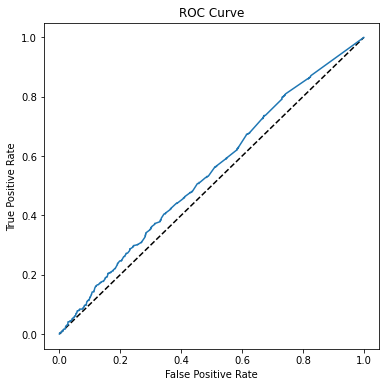

In [49]:
y_pred_prob = rf.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.figure(figsize=(6,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

In [44]:
# Compute and print AUC score
print("AUC: {:.4f}".format(roc_auc_score(y_test, y_pred_prob)))

AUC: 0.5375


It appears that the variables chosen are pretty poor at predicting a user adopting as we see that the AUC for the RF model is only 0.5375. This essentially means you can pick an adopted user through a coin toss.

In [45]:
feature_importance = pd.DataFrame(list(zip(X.columns, rf.feature_importances_)), columns = ['features', 'importance'])
feature_importance.sort_values(by='importance',ascending=False)

,features,importance
2,org_id,0.581926
3,invited_by_user_id,0.251207
4,emailProvider,0.096902
0,opted_in_to_mailing_list,0.019182
1,enabled_for_marketing_drip,0.017115
7,creation_source_PERSONAL_PROJECTS,0.014840
5,creation_source_GUEST_INVITE,0.005925
6,creation_source_ORG_INVITE,0.005887
8,creation_source_SIGNUP,0.003906
9,creation_source_SIGNUP_GOOGLE_AUTH,0.003110


If we were to look at feature importance from the Random Forest model, the top three would be Org ID, Invited by User ID, and Email Provider